# Limited Feature Random Forest Notebook
## Adapted from model_training.ipynb

This runs most of the same code as in model_training.ipynb but with the bulk of it put into functions for easier reusing. Then a new random forest PKL file is created taking the top ten most important features.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import time
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [2]:
np.random.seed(42) 

claims_data = pd.read_csv('ProcessedClaimDataLog.csv')

In [3]:
def identify_columns(claims_data):

    # Identify categorical and numerical columns
    categorical_cols = claims_data.select_dtypes(include=['object', 'string']).columns.tolist()
    numerical_cols = claims_data.select_dtypes(include=['int64', 'float64']).columns.tolist()

    # Remove the target variable from the feature lists
    target_col = 'LogSettlementValue'

    # Remove both the log-transformed target AND the original settlement value from features
    if target_col in numerical_cols:
        numerical_cols.remove(target_col)
    if 'SettlementValue' in numerical_cols: 
        numerical_cols.remove('SettlementValue') 

    print(f"\nCategorical columns: {categorical_cols}")
    print(f"Numerical columns: {numerical_cols}")
    print(f"Target column: {target_col}")

    return categorical_cols, numerical_cols, target_col

# Update categorical and numerical columns based on the transformed dataset
def define_preprocessor(X_train):
    categorical_cols, numerical_cols, _ = identify_columns(claims_data=claims_data)

    categorical_cols = [col for col in categorical_cols if col in X_train.columns]
    numerical_cols = [col for col in numerical_cols if col in X_train.columns]

    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_cols),
            ('cat', categorical_transformer, categorical_cols)
    ])

    return preprocessor

# Function to evaluate a model
def evaluate_model(model, X, y, model_name):
    y_pred = model.predict(X)
    mse = mean_squared_error(y, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    
    return {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R^2': r2,
        'Name': model_name
    }

In [4]:
if 'AccidentDate' in claims_data.columns and 'ClaimDate' in claims_data.columns:
    claims_data['DaysBetweenAccidentAndClaim'] = claims_data['ClaimDate'] - claims_data['AccidentDate']

categorical_cols, numerical_cols, target_col = identify_columns(claims_data=claims_data)


Categorical columns: ['AccidentType', 'DominantInjury', 'VehicleType', 'WeatherConditions', 'AccidentDescription', 'InjuryDescription', 'Gender']
Numerical columns: ['InjuryPrognosis', 'SpecialHealthExpenses', 'SpecialReduction', 'SpecialOverage', 'GeneralRest', 'SpecialAdditionalInjury', 'SpecialEarningsLoss', 'SpecialUsageLoss', 'SpecialMedications', 'SpecialAssetDamage', 'SpecialRehabilitation', 'SpecialFixes', 'GeneralFixed', 'GeneralUplift', 'SpecialLoanerVehicle', 'SpecialTripCosts', 'SpecialJourneyExpenses', 'SpecialTherapy', 'ExceptionalCircumstances', 'MinorPsychologicalInjury', 'Whiplash', 'AccidentDate', 'ClaimDate', 'VehicleAge', 'DriverAge', 'NumberOfPassengers', 'PoliceReportFiled', 'WitnessPresent', 'DaysBetweenAccidentAndClaim']
Target column: LogSettlementValue


In [5]:
# Splitting data
X = claims_data.drop(columns=[target_col])
y = claims_data[target_col]

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

print(f"\nTraining set size: {X_train.shape[0]} samples")
print(f"Validation set size: {X_val.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")


Training set size: 2577 samples
Validation set size: 860 samples
Test set size: 860 samples


In [6]:
def execute_pipeline(models, preprocesser):
    # Dictionary to store model results
    model_results = {}
    print("\nTraining and evaluating models:")

    for name, model in models.items():
        start_time = time.time()
        
        # Create pipeline with preprocessing and model
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocesser),
            ('model', model)
        ])
        
        # Train the model
        print(f"Training {name}...")
        pipeline.fit(X_train, y_train)
        
        # Evaluate on validation set
        results = evaluate_model(pipeline, X_val, y_val, name)
        results['Training Time'] = time.time() - start_time
        model_results[name] = results
        
        print(f"  {name} - RMSE: {results['RMSE']:.2f}, R^2: {results['R^2']:.4f}, Time: {results['Training Time']:.2f}s")
        
        # Store the pipeline
        model_results[name]['pipeline'] = pipeline

    # using RSMe to compare the models
    best_model_name = min(model_results, key=lambda k: model_results[k]['RMSE'])
    print(f"\nBest model based on validation RMSE: {best_model_name}")
    best_pipeline = model_results[best_model_name]['pipeline']

    return best_model_name, best_pipeline, model_results

def model_tuner(best_pipeline, param_grid, model_results):
    # only performs hyperparameter tuning if we have parameters to tune
    if param_grid:
        best_model_name = best_pipeline['model'].__class__.__name__

        print(f"\nPerforming hyperparameter tuning for {best_model_name}...")
        
        # cross validation 
        grid_search = GridSearchCV(
            best_pipeline,
            param_grid,
            cv=5,
            scoring='neg_root_mean_squared_error',
            n_jobs=-1,
            verbose=1
        )
        
        grid_search.fit(X_train, y_train)
        
        print(f"Best parameters: {grid_search.best_params_}")
        best_pipeline = grid_search.best_estimator_
        
        tuned_results = evaluate_model(best_pipeline, X_val, y_val, f"{best_model_name} (Tuned)")
        print(f"Tuned model - RMSE: {tuned_results['RMSE']:.2f}, R^2: {tuned_results['R^2']:.4f}")
        
        model_results[f"{best_model_name} (Tuned)"] = tuned_results
        model_results[f"{best_model_name} (Tuned)"]['pipeline'] = best_pipeline
        
        if tuned_results['RMSE'] < model_results[best_model_name]['RMSE']:
            best_model_name = f"{best_model_name} (Tuned)"

    return best_pipeline, param_grid, model_results


In [7]:
# Define a list of models to try
models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(),
    'RandomForestRegressor': RandomForestRegressor(random_state=42),
}

preprocessor = define_preprocessor(claims_data)

best_model_name, best_pipeline, model_results = execute_pipeline(models=models, preprocesser=preprocessor)
# Tuning the best hyperparameter Tuning for the Best Model
param_grid = {}

if best_model_name == 'LinearRegression':
    # regression model does not have hyperparameters to tune but best to keep this to keep track 
    pass
elif best_model_name == 'Ridge':
    param_grid = {
        'model__alpha': [0.01, 0.1, 1.0, 10.0, 100.0]
    }
elif best_model_name == 'RandomForestRegressor':
    param_grid = {
        'model__n_estimators': [100, 200],
        'model__max_depth': [None, 10, 20],
        'model__min_samples_split': [2, 5],
    }


Categorical columns: ['AccidentType', 'DominantInjury', 'VehicleType', 'WeatherConditions', 'AccidentDescription', 'InjuryDescription', 'Gender']
Numerical columns: ['InjuryPrognosis', 'SpecialHealthExpenses', 'SpecialReduction', 'SpecialOverage', 'GeneralRest', 'SpecialAdditionalInjury', 'SpecialEarningsLoss', 'SpecialUsageLoss', 'SpecialMedications', 'SpecialAssetDamage', 'SpecialRehabilitation', 'SpecialFixes', 'GeneralFixed', 'GeneralUplift', 'SpecialLoanerVehicle', 'SpecialTripCosts', 'SpecialJourneyExpenses', 'SpecialTherapy', 'ExceptionalCircumstances', 'MinorPsychologicalInjury', 'Whiplash', 'AccidentDate', 'ClaimDate', 'VehicleAge', 'DriverAge', 'NumberOfPassengers', 'PoliceReportFiled', 'WitnessPresent', 'DaysBetweenAccidentAndClaim']
Target column: LogSettlementValue

Training and evaluating models:
Training LinearRegression...
  LinearRegression - RMSE: 0.37, R^2: 0.6863, Time: 0.75s
Training Ridge...
  Ridge - RMSE: 0.37, R^2: 0.6867, Time: 0.35s
Training RandomForestRegr

In [8]:
best_pipeline, param_grid, model_results = model_tuner(best_pipeline, param_grid, model_results)

# Evaluate the best model on the test set
best_pipeline = model_results[best_model_name]['pipeline']
test_results = evaluate_model(best_pipeline, X_test, y_test, best_model_name)
print(f"\nTest set evaluation for {best_model_name}:")
print(f"  RMSE: {test_results['RMSE']:.2f}")
print(f"  MAE: {test_results['MAE']:.2f}")
print(f"  R^2: {test_results['R^2']:.4f}")


Performing hyperparameter tuning for RandomForestRegressor...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters: {'model__max_depth': None, 'model__min_samples_split': 2, 'model__n_estimators': 200}
Tuned model - RMSE: 0.20, R^2: 0.9051

Test set evaluation for RandomForestRegressor:
  RMSE: 0.18
  MAE: 0.10
  R^2: 0.9211


In [9]:
def predicted_settlement_plot(y_pred_test, y_test, best_model_name):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred_test, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual Settlement Values')
    plt.ylabel('Predicted Settlement Values')
    plt.title(f'Actual vs. Predicted Settlement Values ({best_model_name})')
    plt.tight_layout()
    plt.show()

def residual_plot(y_test, y_pred_test):
    # Calculate residuals
    residuals = y_test - y_pred_test

    plt.figure(figsize=(10, 6))
    plt.scatter(y_pred_test, residuals, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicted Settlement Values')
    plt.ylabel('Residuals')
    plt.title('Residual Plot')
    plt.tight_layout()
    plt.show()

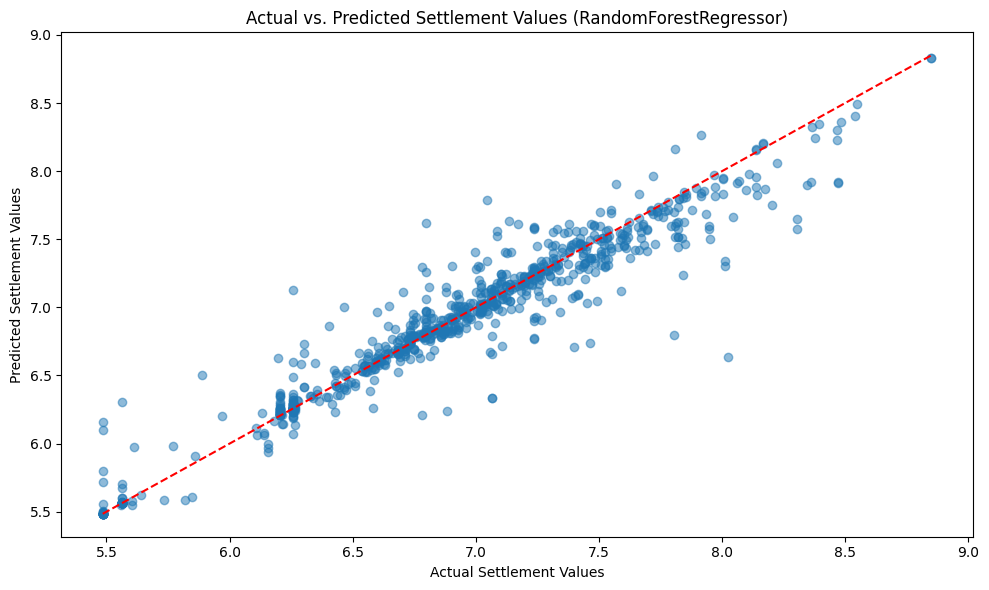

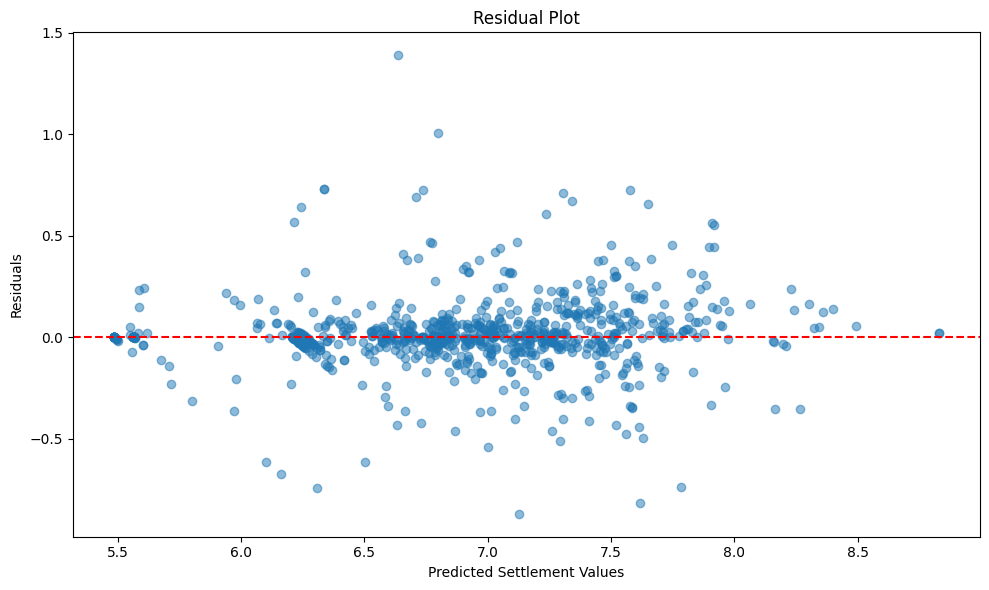

In [10]:
y_pred_test = best_pipeline.predict(X_test)

predicted_settlement_plot(y_test=y_test, y_pred_test=y_pred_test, best_model_name=best_model_name)
residual_plot(y_test=y_test, y_pred_test=y_pred_test)

In [11]:
def important_features_calc(best_pipeline):
    # Get feature names after preprocessing
    if categorical_cols:
        # Get feature names from the preprocessor
        preprocessor = best_pipeline.named_steps['preprocessor']
        feature_names = []
        
        # Get numerical feature names
        if numerical_cols:
            feature_names.extend(numerical_cols)
        
        # Get one-hot encoded feature names
        if categorical_cols:
            ohe = preprocessor.named_transformers_['cat'].named_steps['onehot']
            # Get category names from one-hot encoder
            cat_features = ohe.get_feature_names_out(categorical_cols)
            feature_names.extend(cat_features)
    else:
        feature_names = numerical_cols

    # For tree-based models, we can get feature importance directly
    if hasattr(best_pipeline.named_steps['model'], 'feature_importances_'):
        importances = best_pipeline.named_steps['model'].feature_importances_
        feature_imp = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importances
        }).sort_values('Importance', ascending=False)
        
        # Plot feature importance
        plt.figure(figsize=(12, 8))
        sns.barplot(x='Importance', y='Feature', data=feature_imp.head(20))
        plt.title(f'Top 20 Feature Importances ({best_model_name})')
        plt.tight_layout()
        plt.show()
        
        print("\nTop 10 important features:")
        print(feature_imp.head(10))
    else:
        # For linear models, use coefficients
        if hasattr(best_pipeline.named_steps['model'], 'coef_'):
            coefs = best_pipeline.named_steps['model'].coef_
            
            if coefs.ndim == 1:  # For models with a 1D coefficient array
                feature_imp = pd.DataFrame({
                    'Feature': feature_names,
                    'Coefficient': coefs
                }).sort_values('Coefficient', key=abs, ascending=False)
                
                # Plot coefficient values
                plt.figure(figsize=(12, 8))
                sns.barplot(x='Coefficient', y='Feature', data=feature_imp.head(20))
                plt.title(f'Top 20 Feature Coefficients ({best_model_name})')
                plt.tight_layout()
                plt.show()
                
                print("\nTop 10 features by coefficient magnitude:")
                print(feature_imp.head(10))
        else:
            # Permutation importance for models without built-in feature importance
            print("\nCalculating permutation importance...")
            perm_importance = permutation_importance(
                best_pipeline, X_val, y_val, n_repeats=10, random_state=42, n_jobs=-1
            )
            
            feature_imp = pd.DataFrame({
                'Feature': feature_names,
                'Importance': perm_importance.importances_mean
            }).sort_values('Importance', ascending=False)

    return feature_imp

def permutation_importance_plotting(feature_imp):
    # Plot permutation importance
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_imp.head(20))
    plt.title(f'Top 20 Permutation Importances ({best_model_name})')
    plt.tight_layout()
    plt.show()

    print("\nTop 10 features by permutation importance:")
    print(feature_imp.head(10))

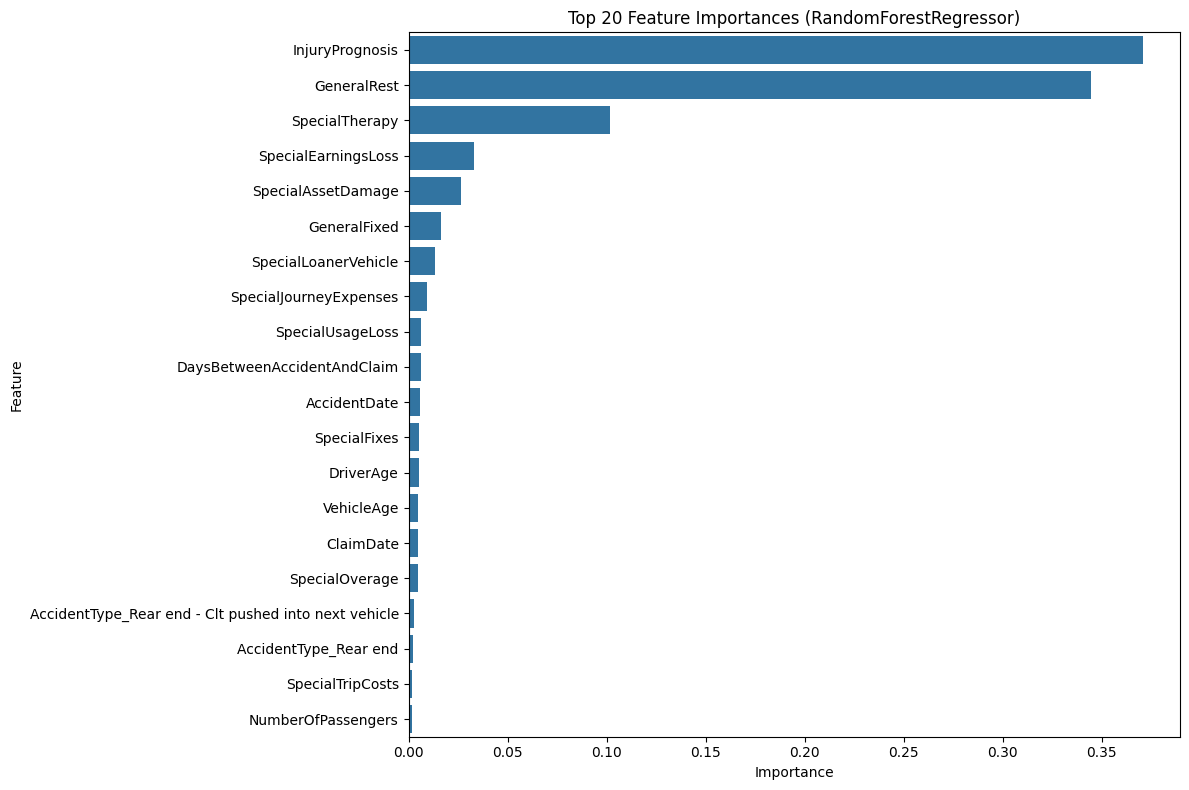


Top 10 important features:
                        Feature  Importance
0               InjuryPrognosis    0.371062
4                   GeneralRest    0.344919
17               SpecialTherapy    0.101556
6           SpecialEarningsLoss    0.033271
9            SpecialAssetDamage    0.026470
12                 GeneralFixed    0.016517
14         SpecialLoanerVehicle    0.013401
16       SpecialJourneyExpenses    0.009256
7              SpecialUsageLoss    0.006434
28  DaysBetweenAccidentAndClaim    0.006375


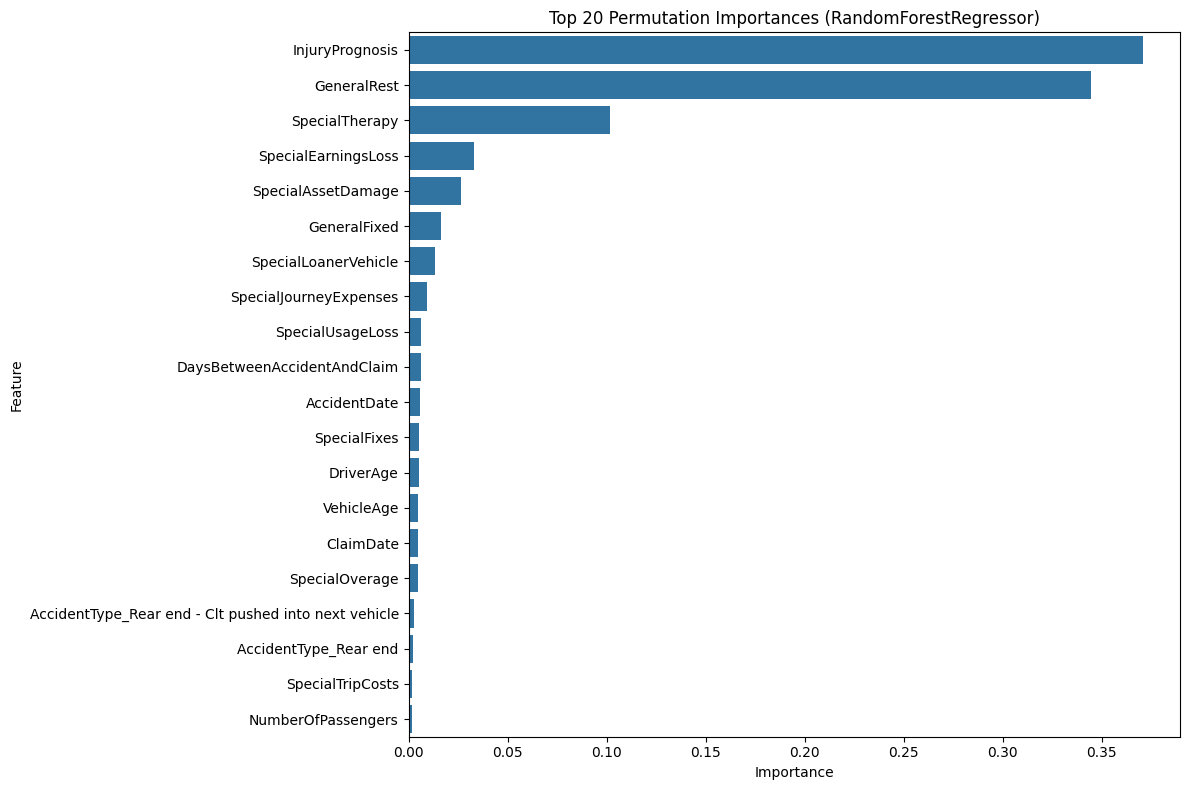


Top 10 features by permutation importance:
                        Feature  Importance
0               InjuryPrognosis    0.371062
4                   GeneralRest    0.344919
17               SpecialTherapy    0.101556
6           SpecialEarningsLoss    0.033271
9            SpecialAssetDamage    0.026470
12                 GeneralFixed    0.016517
14         SpecialLoanerVehicle    0.013401
16       SpecialJourneyExpenses    0.009256
7              SpecialUsageLoss    0.006434
28  DaysBetweenAccidentAndClaim    0.006375


In [12]:
feature_imp = important_features_calc(best_pipeline=best_pipeline)
permutation_importance_plotting(feature_imp=feature_imp)

In [13]:
def gender_bias_plot(X_test_with_preds):
    # Check for biases in predictions by protected characteristics
    if 'Gender' in X_test.columns:
        # Calculate average error by gender
        gender_errors = X_test_with_preds.groupby('Gender')['Error'].mean()
        
        print("\nAverage prediction error by gender:")
        print(gender_errors)

        # Plot gender error comparison
        plt.figure(figsize=(10, 6))
        gender_errors.plot(kind='bar')
        plt.title('Average Prediction Error by Gender')
        plt.ylabel('Mean Absolute Error')
        plt.tight_layout()
        plt.show()
    else:
        print("Gender Column not found!")
    
def age_bias_plot(X_test_with_preds):
    # Check for biases by age
    if 'DriverAge' in X_test.columns:
        # Create age groups
        X_test_with_preds['AgeGroup'] = pd.cut(X_test_with_preds['DriverAge'], 
                                            bins=[0, 30, 40, 50, 60, 70, 80],
                                            labels=['Under 30', '30-40', '40-50', '50-60', '60-70', '70-80'])
        
        # Calculate average error by age group
        age_group_errors = X_test_with_preds.groupby('AgeGroup', observed=False)['Error'].mean()

        print("\nAverage prediction error by age group:")
        print(age_group_errors)

        # Plot age group error comparison
        plt.figure(figsize=(12, 6))
        age_group_errors.plot(kind='bar')
        plt.title('Average Prediction Error by Age Group')
        plt.ylabel('Mean Absolute Error')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    else:
        print("Age Column not found")

def bias_helper(X_test, y_test, y_pred_test):
    # Add predictions to test data
    X_test_with_preds = X_test.copy()
    X_test_with_preds['Predicted'] = y_pred_test
    X_test_with_preds['Actual'] = y_test.values
    X_test_with_preds['Error'] = abs(y_test.values - y_pred_test)

    return X_test_with_preds



Average prediction error by age group:
AgeGroup
Under 30    0.120217
30-40       0.097168
40-50       0.081579
50-60       0.093509
60-70       0.116726
70-80       0.099219
Name: Error, dtype: float64


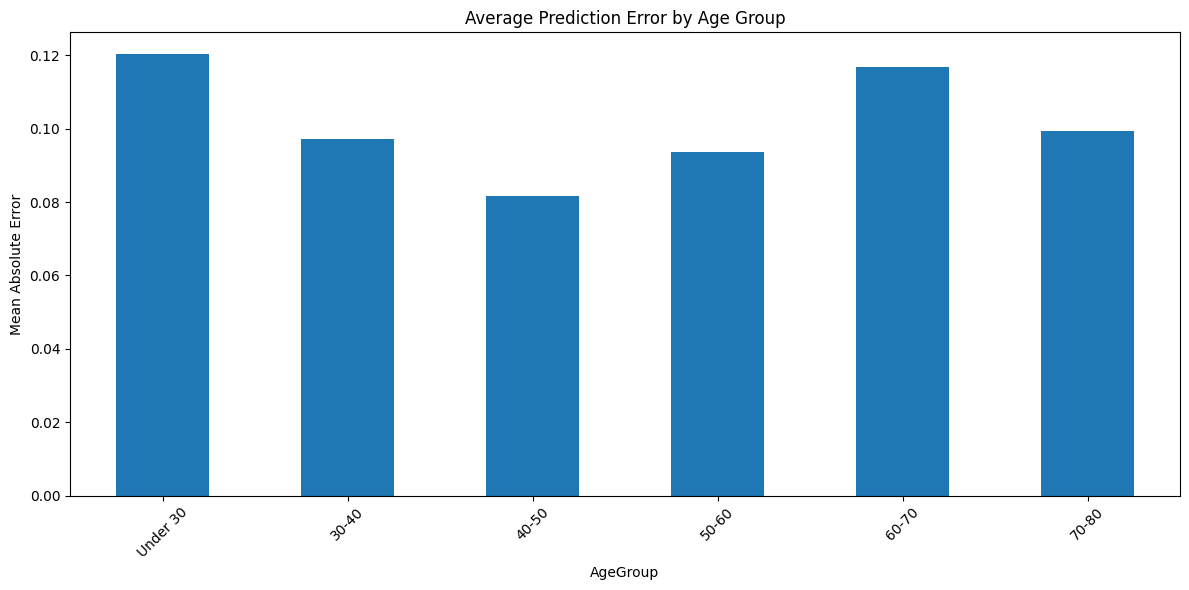


Average prediction error by gender:
Gender
Female    0.103844
Male      0.106266
Other     0.097168
Name: Error, dtype: float64


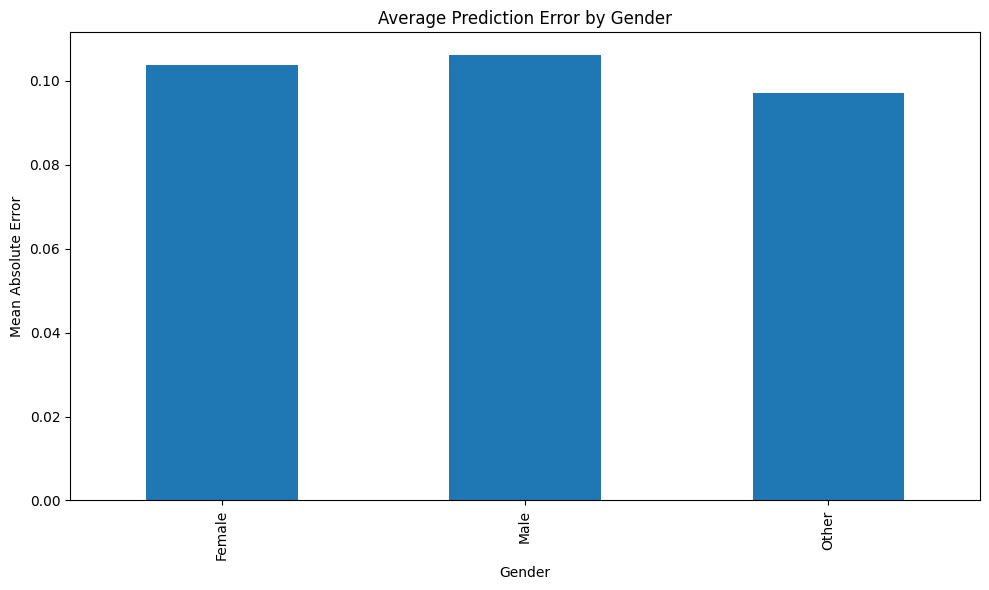

In [14]:
X_test_with_preds = bias_helper(X_test=X_test, y_test=y_test, y_pred_test=y_pred_test)

age_bias_plot(X_test_with_preds=X_test_with_preds)
gender_bias_plot(X_test_with_preds=X_test_with_preds)

## Create Random Forest with only the top ten most important features

In [15]:
top_10 = list(feature_imp.head(10)['Feature'])

X_train_filtered = X_train[top_10]

preprocessor = define_preprocessor(X_train_filtered)

models = {'RandomForestRegressor': RandomForestRegressor(random_state=42),}


Categorical columns: ['AccidentType', 'DominantInjury', 'VehicleType', 'WeatherConditions', 'AccidentDescription', 'InjuryDescription', 'Gender']
Numerical columns: ['InjuryPrognosis', 'SpecialHealthExpenses', 'SpecialReduction', 'SpecialOverage', 'GeneralRest', 'SpecialAdditionalInjury', 'SpecialEarningsLoss', 'SpecialUsageLoss', 'SpecialMedications', 'SpecialAssetDamage', 'SpecialRehabilitation', 'SpecialFixes', 'GeneralFixed', 'GeneralUplift', 'SpecialLoanerVehicle', 'SpecialTripCosts', 'SpecialJourneyExpenses', 'SpecialTherapy', 'ExceptionalCircumstances', 'MinorPsychologicalInjury', 'Whiplash', 'AccidentDate', 'ClaimDate', 'VehicleAge', 'DriverAge', 'NumberOfPassengers', 'PoliceReportFiled', 'WitnessPresent', 'DaysBetweenAccidentAndClaim']
Target column: LogSettlementValue


In [16]:
# Check that all features have transferred over
missing_columns = set(top_10) - set(X_train_filtered.columns)
if missing_columns:
    print(f"Missing columns: {missing_columns}")
else:
    print("All top 10 features are present in the filtered dataset.")

All top 10 features are present in the filtered dataset.


In [17]:
best_model_name, best_pipeline, model_results = execute_pipeline(models=models, preprocesser=preprocessor)

param_grid = {
        'model__n_estimators': [100, 200, 300, 400, 500],
        'model__max_depth': [None, 10, 20, 30, 50],
        'model__min_samples_split': [2, 5],
    }

best_pipeline, param_grid, model_results = model_tuner(best_pipeline, param_grid, model_results)

# Evaluate the best model on the test set
best_pipeline = model_results[best_model_name]['pipeline']
test_results = evaluate_model(best_pipeline, X_test, y_test, best_model_name)
print(f"\nTest set evaluation for {best_model_name}:")
print(f"  RMSE: {test_results['RMSE']:.2f}")
print(f"  MAE: {test_results['MAE']:.2f}")
print(f"  R^2: {test_results['R^2']:.4f}")


Training and evaluating models:
Training RandomForestRegressor...
  RandomForestRegressor - RMSE: 0.21, R^2: 0.9032, Time: 2.54s

Best model based on validation RMSE: RandomForestRegressor

Performing hyperparameter tuning for RandomForestRegressor...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters: {'model__max_depth': 20, 'model__min_samples_split': 2, 'model__n_estimators': 400}
Tuned model - RMSE: 0.21, R^2: 0.9037

Test set evaluation for RandomForestRegressor:
  RMSE: 0.18
  MAE: 0.09
  R^2: 0.9218


In [18]:
best_model_filename = 'limited_model.pkl'
print(f"Saving best model ({best_model_name}) to {best_model_filename}")

with open(best_model_filename, 'wb') as file:
    pickle.dump(best_pipeline, file)
    
print("Model saved successfully!")

Saving best model (RandomForestRegressor) to limited_model.pkl
Model saved successfully!
